In [1]:
"""
Docstring for variable_d_param.ipynb

Trying to implement a variable d-parameter to produce the burst-adaptation 
spike trains in IB neurons

"""




'\nDocstring for variable_d_param.ipynb\n\nTrying to implement a variable d-parameter to produce the burst-adaptation \nspike trains in IB neurons\n\n'

In [2]:
import sys
sys.path.append("..//")

from AQUA_general import AQUA
from batchAQUA_general import batchAQUA
from stimulus import *
from plotting_functions import *

#from AQUAmeetBrian import AQUAMeetBrian


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from brian2 import *

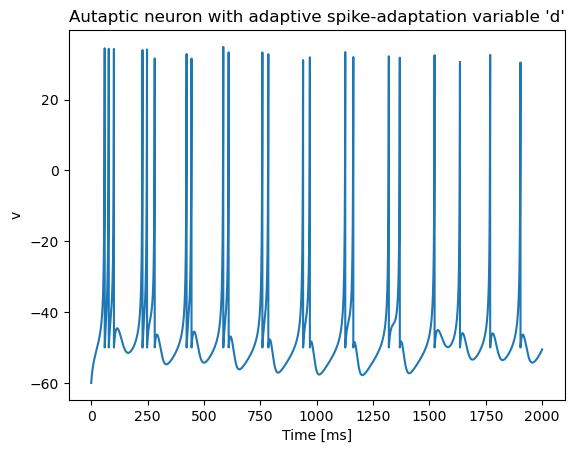

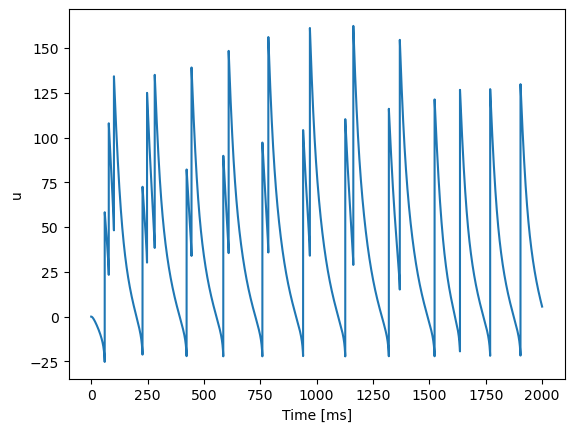

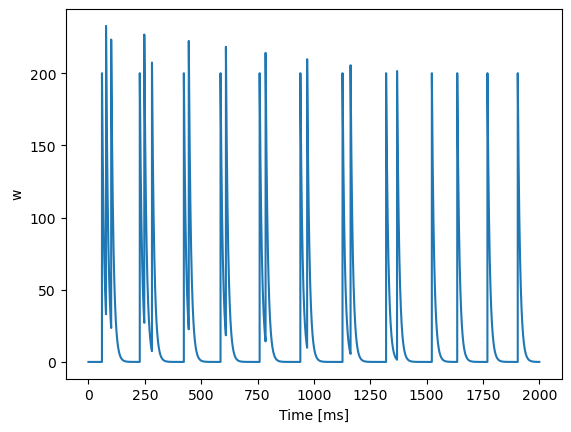

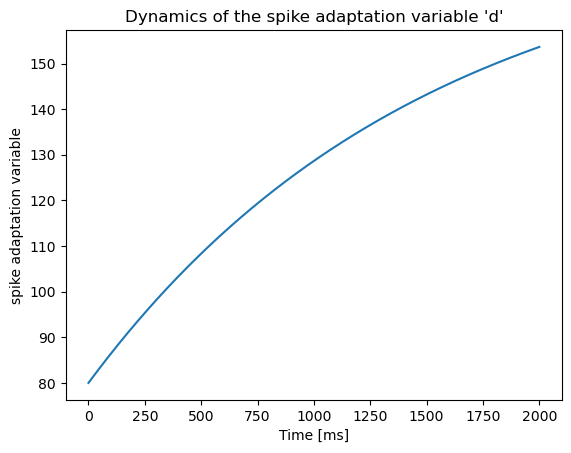

Spike times: [0.0599 0.0779 0.1008 0.2276 0.2476 0.2817 0.4231 0.4449 0.5858 0.6096
 0.7592 0.7856 0.9398 0.9699 1.1268 1.1625 1.3201 1.3687 1.523  1.6356
 1.7695 1.904 ] s


In [16]:
"""
Start with the izhikevich model

AUTAPSE implemented with Synapse class

"""

start_scope()

# adaptation current 'a' needs to be set to 0.02 (instead of 0.03) to reliably produce bursting.
RS = {'name': 'RS', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
     'a': 0.02, 'b': -2, 'c': -50, 'd': 80, 'e_a': 0.1, 'f': 200., 'tau': 0.0}    # Class 1

C = RS['C']
k = RS['k']
v_r = RS['v_r']
v_t = RS['v_t']
a = RS['a']
b = RS['b']
c = RS['c']
d_0 = RS['d']
v_peak = RS['v_peak']
# autapse
e_a = RS['e_a']
f = RS['f']
tau = RS['tau']*ms

## The autapse could be implemented through a time-delayed synapse, or somehow the reset can be delayed manually...
# new differential equation, d increases (slowly but exponentially) towards a large value
# determined by the injected current.

tau_d = 1500*ms
eqs = f'''
dv/dt = ((1/C)*(k *(v-v_r)*(v-v_t) - u + w + I))/ms : 1
du/dt = (a * (b*(v-v_r) - u))/ms : 1
dw/dt = (-e_a*w)/ms : 1
dd/dt = (2*I - d)/tau_d : 1
C : 1
k : 1
v_r : 1
v_t : 1
I : 1
a : 1
b : 1
c : 1
d_0 : 1
tau_d : second
f : 1
e_a : 1
tau : 1
'''


reset = '''
v = c
u += d
'''

G = NeuronGroup(1, eqs, threshold= 'v>=v_peak', reset = reset, method = 'euler')
M_v = StateMonitor(G, 'v', record = 0)
M_u = StateMonitor(G, 'u', record = 0)
M_w = StateMonitor(G, 'w', record = 0)
M_d = StateMonitor(G, 'd', record = 0)
spikemon = SpikeMonitor(G, record = True)

# Synapses
autapse = '''
dw/dt = (-e_a*w)/ms : 1
f : 1
e_a : 1
tau : 1
'''
aut = Synapses(G, G,  
             on_pre='''
             w += f
             ''')
aut.connect(condition = 'i == j')
aut.delay = tau


# Intialise variables
G.v = -60
G.C = C
G.k = k
G.v_r = v_r
G.v_t = v_t
G.a = a
G.b = b
G.I = 90           # the driving current is static in this case
G.c = c
G.d = d_0           # initial spike adaptation
G.tau_d = tau_d     # spike-adaptation adaptation time constant
G.e_a = e_a
G.f = f


duration = 2000*ms
run(duration)


plot(M_v.t/ms, M_v.v[0])
xlabel('Time [ms]')
ylabel('v')
title('Autaptic neuron with adaptive spike-adaptation variable \'d\'')
savefig('adaptive_bursting_spike_train.png')
show()

plot(M_u.t/ms, M_u.u[0])
xlabel('Time [ms]')
ylabel('u')
show()

plot(M_w.t/ms, M_w.w[0])
xlabel('Time [ms]')
ylabel('w')
show()

plot(M_d.t/ms, M_d.d[0])
xlabel('Time [ms]')
ylabel('spike adaptation variable')
title('Dynamics of the spike adaptation variable \'d\'')
savefig('d_dynamics.png')
show()

print(f"Spike times: {spikemon.t[:]}")